In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
root_path = "C:\\Users\\saiki\\OneDrive\\Desktop\\BTech\\data sets\\Rice_Image_Dataset\\Rice_Image_Dataset\\"
class_names = sorted(os.listdir(root_path))[:-1]

In [16]:
file_path = "C:\\Users\\saiki\\OneDrive\\Desktop\\BTech\\data sets\\Rice_Image_Dataset\\Rice_Image_Dataset\\"
filepaths = list(glob.glob(file_path + '/**/*.*'))

In [17]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

In [18]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [19]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 56250 validated image filenames belonging to 5 classes.


In [21]:
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 18750 validated image filenames belonging to 5 classes.


In [22]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100, 100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 18750 validated image filenames belonging to 5 classes.


In [23]:
pretrained_model = EfficientNetB0(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


In [29]:
num_classes = len(train_gen.class_indices)
print(f"Number of Classes: {num_classes}")
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

Number of Classes: 5


In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
my_callbacks = [EarlyStopping(monitor='val_accuracy', patience=2, mode='auto')]

In [32]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 753s 418ms/step - accuracy: 0.9552 - loss: 0.1283 - val_accuracy: 0.9878 - val_loss: 0.0358
Epoch 2/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 725s 412ms/step - accuracy: 0.9871 - loss: 0.0389 - val_accuracy: 0.9900 - val_loss: 0.0286
Epoch 3/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 709s 404ms/step - accuracy: 0.9898 - loss: 0.0300 - val_accuracy: 0.9939 - val_loss: 0.0198
Epoch 4/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 687s 391ms/step - accuracy: 0.9895 - loss: 0.0300 - val_accuracy: 0.9900 - val_loss: 0.0310
Epoch 5/10
1758/1758 ━━━━━━━━━━━━━━━━━━━━ 659s 375ms/step - accuracy: 0.9910 - loss: 0.0240 - val_accuracy: 0.9934 - val_loss: 0.0207


In [62]:
model.save("model_efficientnet_with_conv_layers.keras")

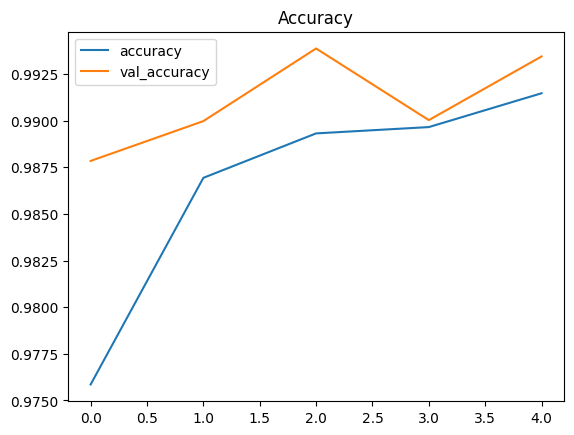

In [36]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

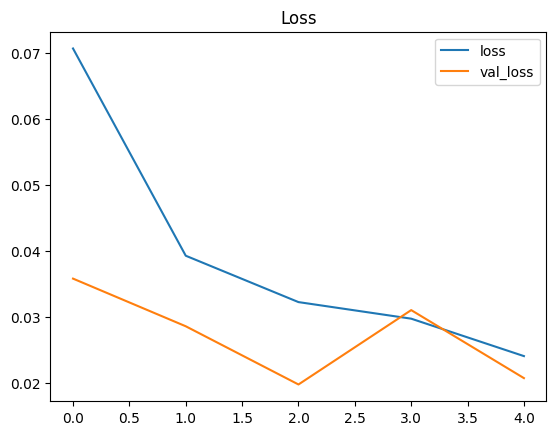

In [37]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [40]:
results = model.evaluate(test_gen, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.02073
Test Accuracy: 99.34%


In [41]:
pred = model.predict(test_gen)
pred_classes = np.argmax(pred, axis=1)

586/586 ━━━━━━━━━━━━━━━━━━━━ 158s 263ms/step


In [42]:
labels = (train_gen.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred_labels = [labels[k] for k in pred_classes]
y_true = list(test.Label)

In [43]:
print(classification_report(y_true, pred_labels))

              precision    recall  f1-score   support

     Arborio       0.99      1.00      0.99      3670
     Basmati       1.00      0.99      0.99      3773
      Ipsala       1.00      1.00      1.00      3757
     Jasmine       0.99      0.99      0.99      3829
   Karacadag       1.00      0.99      0.99      3721

    accuracy                           0.99     18750
   macro avg       0.99      0.99      0.99     18750
weighted avg       0.99      0.99      0.99     18750



In [46]:
conf_matrix = confusion_matrix(y_true, pred_labels, labels=list(labels.values()))
correct_predictions = np.trace(conf_matrix)
incorrect_predictions = np.sum(conf_matrix) - correct_predictions
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

Correct Predictions: 18627
Incorrect Predictions: 123


5
4


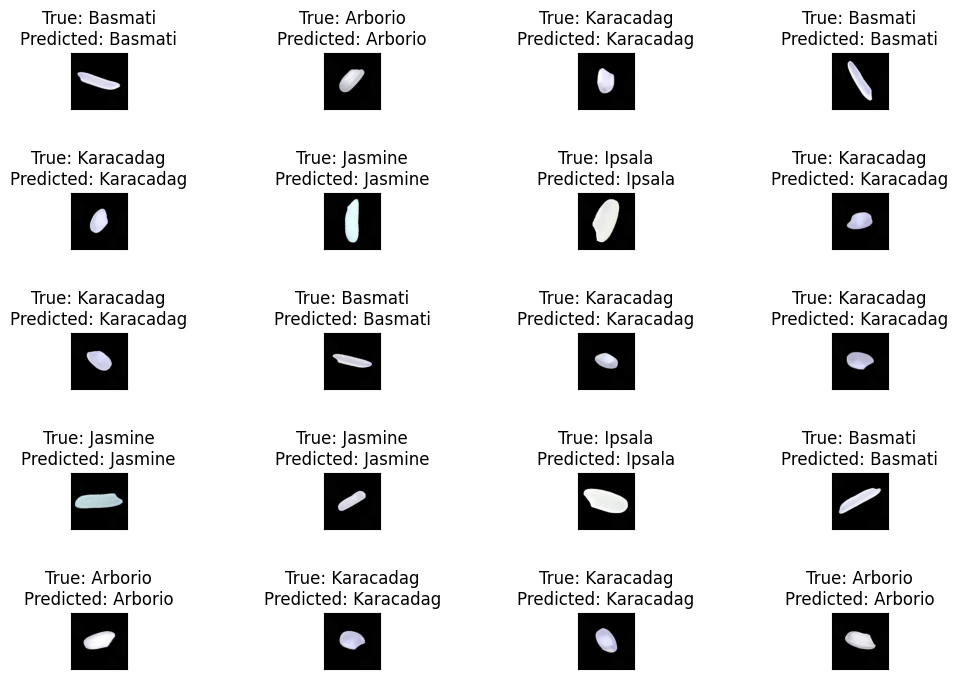

In [61]:
fig, axes = plt.subplots(nrows=int(input()), ncols=int(input()), figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred_labels[i]}")
plt.subplots_adjust(wspace=0.5, hspace=1.5) 
plt.show()

In [63]:
import tensorflow as tf
print(tf.__version__)

2.18.0
